# Spindles and the Hirsch conjecture I

This tutorial showcases more advanced use cases of *Spindles.jl*.
For its basic usage, please read this tutorial first.

## The Hirsch conjecture

The [Hirsch conjecture](https://en.wikipedia.org/wiki/Hirsch_conjecture) for polytopes
stated that any two vertices of a $d$-dimensional polytope with $f$ facets can be connected
by a path of at most $f-d$ edges. It was disproved in 2010 when Francisco Santos found a
[construction](https://arxiv.org/abs/1006.2814) that produces counterexamples from spindles
with a special property: the length of a shortest path between the apices
(called the *length* of the spindle) must be strictly greater than the dimension.

Santos' original counterexample from 2010 is based on a 5-dimensional spindle with 48 facets,
for which the shortest path between the apices is of length 6. The minimal inequality description
of this spindle (see Table 1 in Santos' [paper](https://arxiv.org/pdf/1006.2814)) can be found
in the file `s-48-5.txt` located in the `examples` folder beneath the package root directory `Spindles`.

## Reading a spindle from a file

We may read the description from the file as follows.

In [1]:
using Spindles
A, b, labels = readineq("../../../examples/s-48-5.txt", Int);

In [2]:
[A b]

48×6 Matrix{Rational{Int64}}:
  1   18    0    0    0  1
  1  -18    0    0    0  1
  1    0   18    0    0  1
  1    0  -18    0    0  1
  1    0    0   45    0  1
  1    0    0  -45    0  1
  1    0    0    0   45  1
  1    0    0    0  -45  1
  1   15   15    0    0  1
  1  -15   15    0    0  1
  ⋮                      ⋮
 -1  -30  -30    0    0  1
 -1   40    0   10    0  1
 -1   40    0  -10    0  1
 -1  -40    0   10    0  1
 -1  -40    0  -10    0  1
 -1    0   40    0   10  1
 -1    0   40    0  -10  1
 -1    0  -40    0   10  1
 -1    0  -40    0  -10  1

The function `readineq` does not only return the data in the inequality description
$Ax \le b$ from the source but also the attached labels, one for each inequality.

In [3]:
labels

48-element Vector{String}:
 "1+"
 "1-"
 "2+"
 "2-"
 "3+"
 "3-"
 "4+"
 "4-"
 "5+"
 "5-"
 ⋮
 "20-"
 "21+"
 "21-"
 "22+"
 "22-"
 "23+"
 "23-"
 "24+"
 "24-"

> **Note**
>
> Even though we use the same set of labels as Santos in his [paper](https://arxiv.org/pdf/1006.2814),
> the assignment to the rows of `A` is different.

The apices are

In [4]:
s = Spindle(A, b)
collect(vertices(s))[apices(s)]

2-element Vector{Vector{Rational{Int64}}}:
 [-1, 0, 0, 0, 0]
 [1, 0, 0, 0, 0]

and the distance between them in the graph of `s` is indeed 6:

In [5]:
dist(s, apices(s)...)

6

Note that both apices are highly degenerate:

In [6]:
using Graphs: degree
degree(graph(s), apices(s))

2-element Vector{Int64}:
 32
 32

## Inspecting faces

The original motivation for developing *Spindles.jl* was the search for special two-dimensional faces
(or *2-faces* for short) of the spindle `s` and similar spindles.
To explain what we mean by "special", let us consider the following three facets:

In [7]:
face = [29, 37, 41]
labels[face]

3-element Vector{String}:
 "15+"
 "19+"
 "21+"

They indeed define a 2-face of `s`:

In [8]:
face in facesofdim(s, 2)

true

We may use the function `plot2face` provided by *Spindles.jl* to plot the graph of this face.

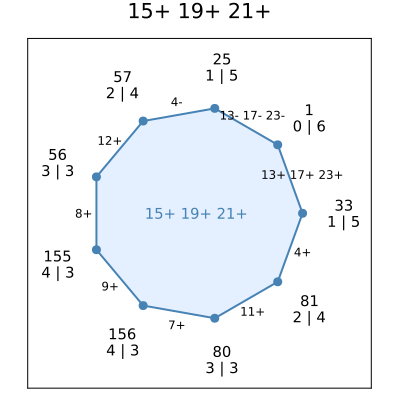

In [9]:
plot2face(s, face; facetlabels=labels, showdist=true, figsize=(400,400))

As one would expect from a 2-face, the graph is a cycle. Each vertex is labeled by its index
(on the first line) and the distance to each of the two apices of `s` (on the second line).
For example, `1 | 5` in the label of vertex `25` means that `25` is one edge step away from
the first apex `apices(s)[1]` and five steps away from `apices(s)[2]`.
Likewise, the label `0 | 6` for vertex `1` means that `1` is at distance 0 from `apices(s)[1]`.
This should not be surprising given that `1` *is* the index of the first apex:

In [10]:
apices(s)

2-element Vector{Int64}:
   1
 100

Edges are labeled by their incident facets, where the three facets that define the face are omitted.

## Good 2-faces

Note that for each vertex in the plot above, the sum of both distances must be at least 6
because we know that there is no shorter path between the apices. In fact, there are two such
shortest paths that traverse parts of the face: Starting at the first apex `1`, we may take
3 steps to either `56` or `80`. Both vertices are at distance 3 from the second apex,
as their labels tell us.
The only two vertices that are not visited on either of those two paths are `155` and `156`,
and they are also at distance 3 from the second apex.

So among the vertices of the face `15+ 19+ 21+`, there are two special subsets:
One subset of vertices, let us call it $V_1$, is "close" to the first apex
(namely, take $V_1$ to be the apex `1 ` itself). The other subset $V_2$
(the subset consisting of `56`, `155`, `156`, and `80`) is disjoint from the
first one, and each vertex in $V_2$ is "close" to second apex . Here, "close" means that
if we pick two arbitrary vertices, one from each subset, then the sum of their distances
to the respectively closest apex is at most 3, which is 2 less than the dimension of `s`.
Moreover, each vertex in $V_2$ is at least 3 edge steps away from $V_1$ on the face.

Let us call 2-faces with this property *good*. Good 2-faces play an important role for
analyzing `s` in the setting of the so-called *circuit diameter conjecture*, a relaxation
of the Hirsch conjecture. *Spindles.jl* provides a function `isgood2face` that tests
a face for being good.

In [11]:
isgood2face(s, face)

Spindles.FaceState(true, [29, 37, 41], ([25, 57], [81, 33]), ([1], [56, 155, 156, 80]))

The result is wrapped in a bespoke data type called
`FaceState`. The field `good` indicates whether or not
the tested face is good, and the two vertex sets $V_1$ and $V_2$ that certify the property
of being good are stored in the field `vsets` (see also the documentation on the
`FaceState` type):

In [12]:
fstate = isgood2face(s, face)
fstate.good, fstate.vsets

(true, ([1], [56, 155, 156, 80]))

Let us plot it again, but this time not as a graph but as a two-dimensional projection.
This is achieved by setting the option `usecoordinates` to `true`:

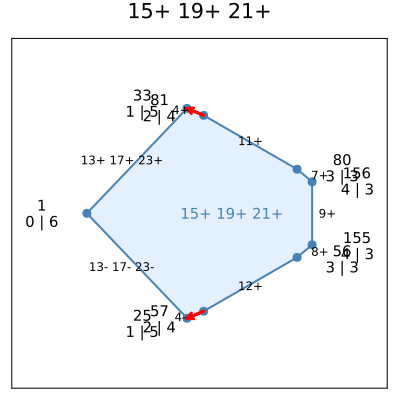

In [13]:
plot2face(
	s, face; facetlabels=labels,
	showdist=true, usecoordinates=true, directed_edges=fstate.edges, figsize=(400,400)
)

We may also enumerate all good 2-faces of `s` as follows.

In [14]:
for f in sort(facesofdim(s, 2))
    if isgood2face(s, f).good
        println(join(labels[f], " "))
    end
end

3+ 7+ 9+
3+ 7+ 9-
3+ 8+ 9+
3+ 8+ 9-
3- 7- 10+
3- 7- 10-
3- 8- 10+
3- 8- 10-
4+ 7+ 11+
4+ 7+ 11-
4+ 7- 11+
4+ 7- 11-
4- 8+ 12+
4- 8+ 12-
4- 8- 12+
4- 8- 12-
15+ 19+ 21+
15+ 19+ 21-
15+ 20+ 21+
15+ 20+ 21-
15- 19- 22+
15- 19- 22-
15- 20- 22+
15- 20- 22-
16+ 19+ 23+
16+ 19+ 23-
16+ 19- 23+
16+ 19- 23-
16- 20+ 24+
16- 20+ 24-
16- 20- 24+
16- 20- 24-


In particular, for each good 2-face, there must exist paths from both apices to
some vertex on the face of total length at most 3.
Interestingly, all 2-faces of `s` that satisfy this weaker condition are good:

In [15]:
for f in sort(facesofdim(s, 2))
	min_total_length = sum(
		minimum(
			dist(s, a, v) for v in incidentvertices(s, f)
		) for a in apices(s)
	)
	if min_total_length <= 3
		println(join(labels[f], " "), "\t", isgood2face(s, f).good)
	end
end

3+ 7+ 9+	true
3+ 7+ 9-	true
3+ 8+ 9+	true
3+ 8+ 9-	true
3- 7- 10+	true
3- 7- 10-	true
3- 8- 10+	true
3- 8- 10-	true
4+ 7+ 11+	true
4+ 7+ 11-	true
4+ 7- 11+	true
4+ 7- 11-	true
4- 8+ 12+	true
4- 8+ 12-	true
4- 8- 12+	true
4- 8- 12-	true
15+ 19+ 21+	true
15+ 19+ 21-	true
15+ 20+ 21+	true
15+ 20+ 21-	true
15- 19- 22+	true
15- 19- 22-	true
15- 20- 22+	true
15- 20- 22-	true
16+ 19+ 23+	true
16+ 19+ 23-	true
16+ 19- 23+	true
16+ 19- 23-	true
16- 20+ 24+	true
16- 20+ 24-	true
16- 20- 24+	true
16- 20- 24-	true


If you would like to explore one of the actual counterexamples to the Hirsch conjecture
that was built from a spindle like `s`, please read on

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*